##**Context**
This is a [Dataset](https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset) Created as a part of the university Project On Sentimental Analysis On Multi-Source Social Media Platforms using PySpark.

There two datasets Respectively one Consists of Tweets from Twitter with Sentimental Label and the other from Reddit which Consists of Comments with its Sentimental Label.

Twitter Dataset
2.Reddit Dataset

All these Tweets and Comments were extracted using there Respective Apis Tweepy and PRAW.
These tweets and Comments Were Made on Narendra Modi and Other Leaders as well as Peoples Opinion Towards the Next Prime Minister of The Nation ( In Context with General Elections Held In India - 2019).
All the Tweets and Comments From twitter and Reddit are Cleaned using Pythons re and also NLP with a Sentimental Label to each ranging from -1 to 1.

- 0 Indicating it is a Neutral Tweet/Comment
- 1 Indicating a Postive Sentiment
- -1 Indicating a Negative Tweet/Comment

In [ ]:
import numpy as np
#from emo_utils import *
#import emoji
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

from keras import regularizers


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
home = "/content/gdrive/MyDrive/Corsi/cycle1/Text Mining and NLP - Prof. Marinai/Project"

Mounted at /content/gdrive


In [ ]:
url = "https://raw.githubusercontent.com/gobrac/datasets/main/Reddit_Data.csv" 
df = pd.read_csv(url)
#df.index = df['date']
df.head(5)

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


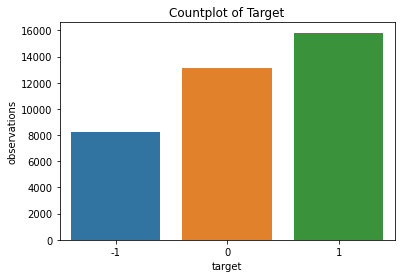

In [ ]:
ax = sns.countplot(x="category", data=df)
plt.title('Countplot of Target')
plt.xlabel('target')
plt.ylabel('observations')
plt.show()

#CNN

In [ ]:
df.category.value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

The sentences present in the dataset seems to be already cleaned. However, we apply a standardization to remove anything that's not alphanumeric or a space. Then we lowercase what's left.

In [ ]:
def clean_str(in_str):
    in_str = str(in_str)

    # clean text
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    
    return in_str.strip().lower()


df['text'] = df['clean_comment'].apply(clean_str)

In [ ]:
df

,clean_comment,category,text
0,family mormon have never tried explain them t...,1,family mormon have never tried explain them th...
1,buddhism has very much lot compatible with chr...,1,buddhism has very much lot compatible with chr...
2,seriously don say thing first all they won get...,-1,seriously don say thing first all they won get...
3,what you have learned yours and only yours wha...,0,what you have learned yours and only yours wha...
4,for your own benefit you may want read living ...,1,for your own benefit you may want read living ...
...,...,...,...
37244,jesus,0,jesus
37245,kya bhai pure saal chutiya banaya modi aur jab...,1,kya bhai pure saal chutiya banaya modi aur jab...
37246,downvote karna tha par upvote hogaya,0,downvote karna tha par upvote hogaya
37247,haha nice,1,haha nice


Since we have a different proportion of observation for each category, we randomly down-sample each target category to the amount of the smallest one

In [ ]:
df_0 = df[df['category'] == -1].sample(frac=1)
df_1 = df[df['category'] == 0].sample(frac=1)
df_2 = df[df['category'] == 1].sample(frac=1)


# we want a balanced set for training against - there are 8277 `-1` examples
sample_size = min(df.category.value_counts())

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size)]).sample(frac=1)

In [ ]:
data=df

In [ ]:
data['l'] = data['clean_comment'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 30.464710462025828
max length of sentence: 1308
std dev length of sentence: 56.4559664282472


In [ ]:
data.category.value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

In [ ]:
sequence_length = 1500

In [ ]:
max_words = 20000 # this is the max number of words considered


tokenizer = Tokenizer(num_words=max_words, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['text'].values)



# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(data['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X   = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['category']).values

# where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  


print("train set size " + str(len(X_train)))
print("test set size " + str(len(X_test)))


train set size 29799
test set size 7450


##Model 1: Random embeddings

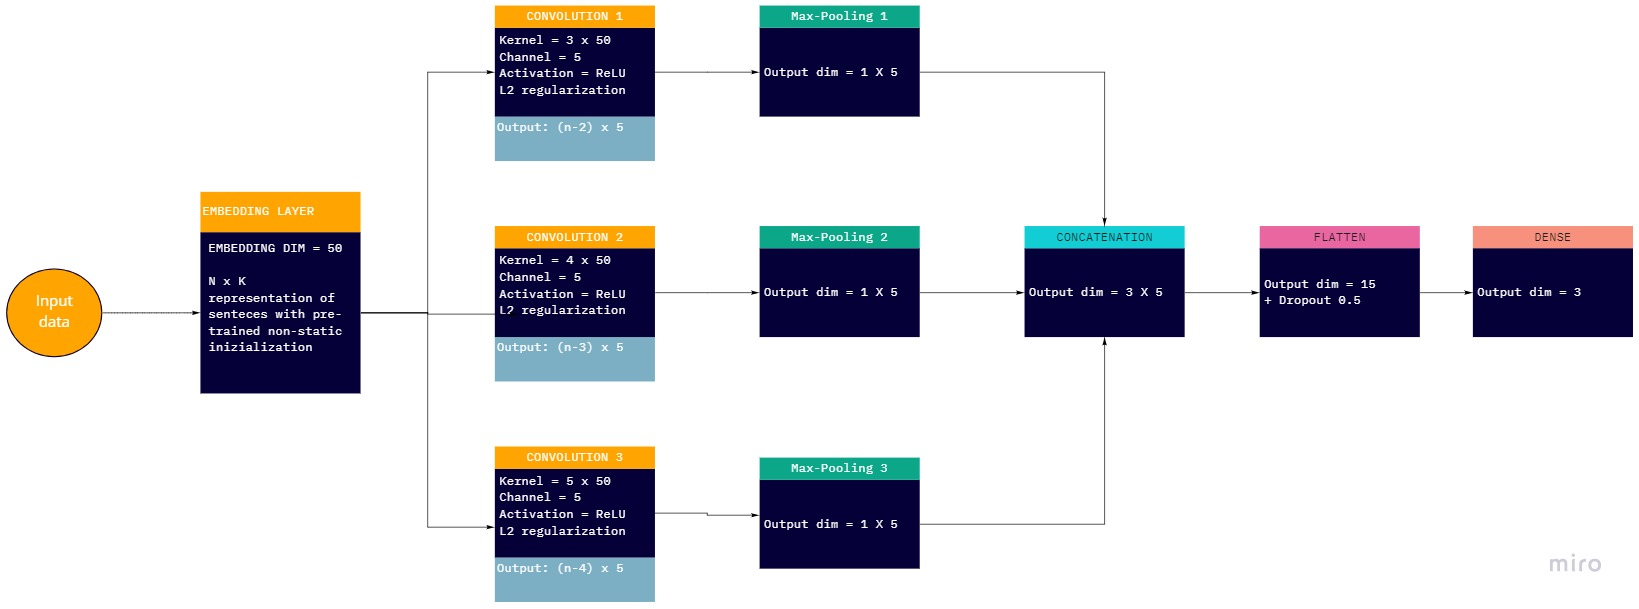


In [ ]:
embedding_dim = 50 
num_filters = 5

inputs = Input(shape=(sequence_length,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_words, 
                            output_dim=embedding_dim, 
                            input_length=sequence_length,
                            trainable=True)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# relu activation
# The convolution window acts on the whole 50 dimensions 
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape) #Regularizer to apply an L2 penalty on the layer's kernel
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

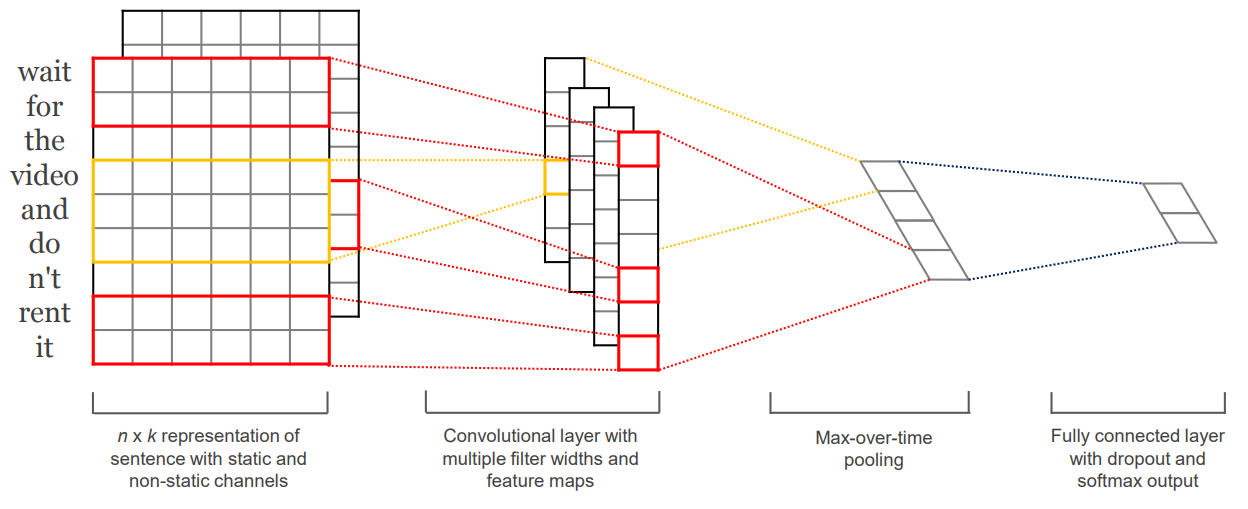

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 50)     1000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1500, 50, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1498, 1, 5)   755         reshape[0][0]                    
______________________________________________________________________________________________

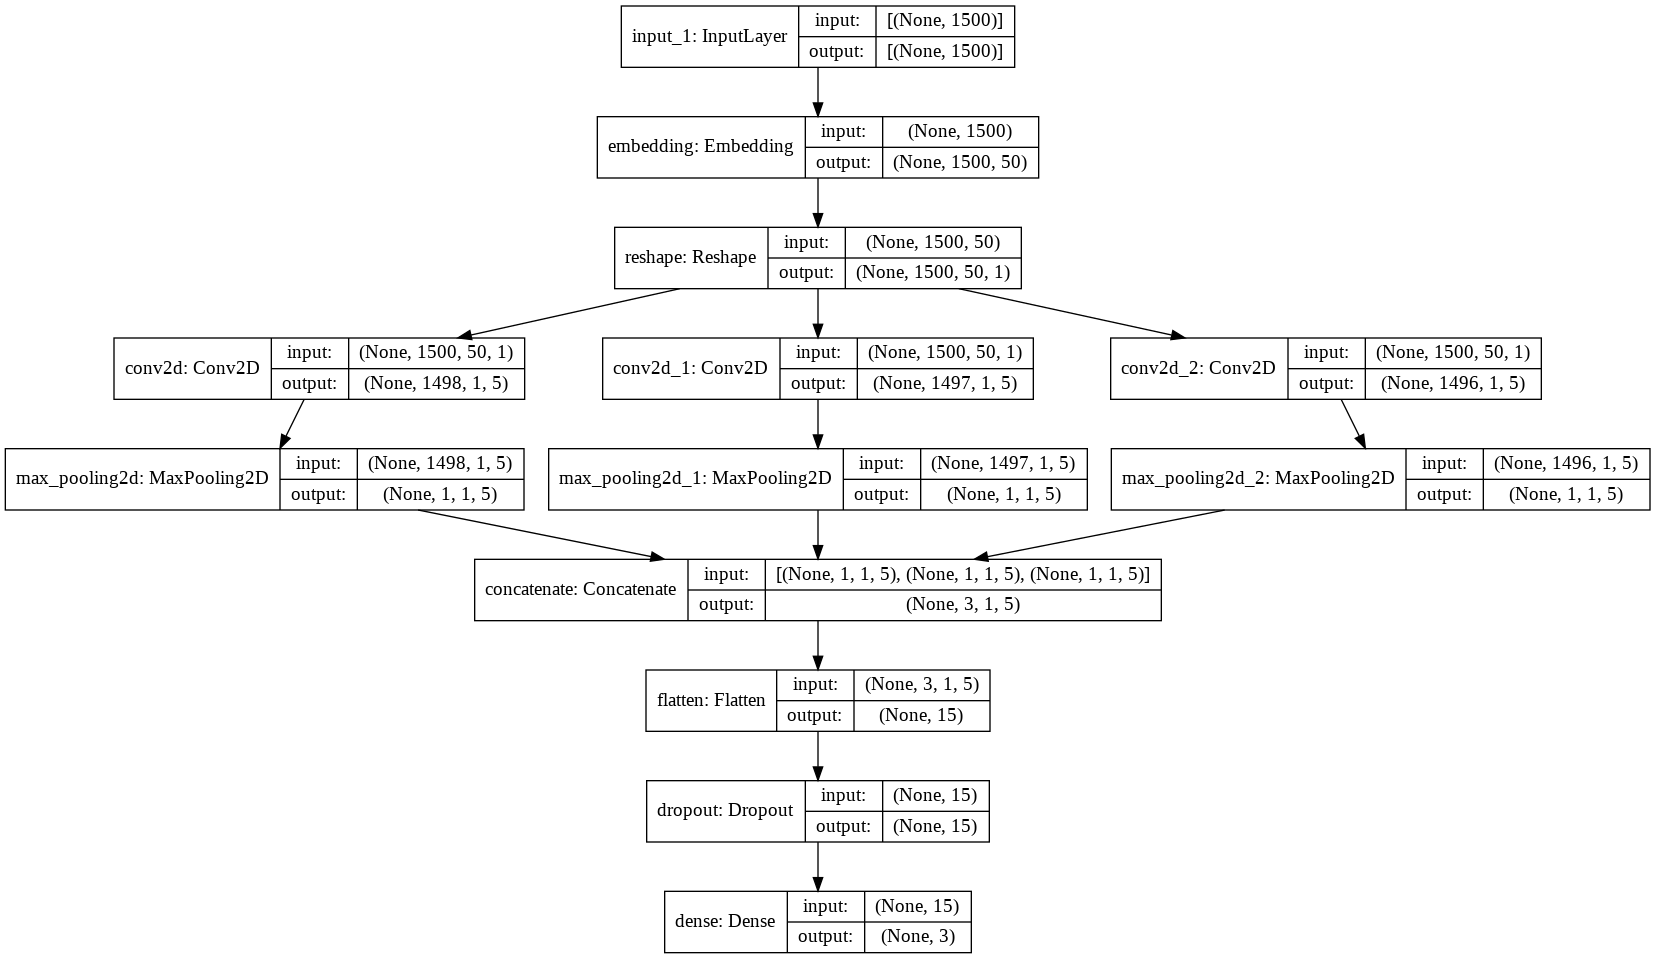

In [ ]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
tf.keras.utils.plot_model(model,  show_shapes=True)


In [ ]:
batch_size = 50 
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/20
477/477 [==============================] - 18s 38ms/step - loss: 1.0499 - accuracy: 0.4599 - val_loss: 1.0203 - val_accuracy: 0.5295
Epoch 2/20
477/477 [==============================] - 18s 37ms/step - loss: 1.0042 - accuracy: 0.5954 - val_loss: 0.9311 - val_accuracy: 0.7074
Epoch 3/20
477/477 [==============================] - 17s 37ms/step - loss: 0.8853 - accuracy: 0.6793 - val_loss: 0.7714 - val_accuracy: 0.7455
Epoch 4/20
477/477 [==============================] - 18s 37ms/step - loss: 0.7678 - accuracy: 0.7184 - val_loss: 0.6941 - val_accuracy: 0.7597
Epoch 5/20
477/477 [==============================] - 18s 37ms/step - loss: 0.7079 - accuracy: 0.7304 - val_loss: 0.6484 - val_accuracy: 0.7628
Epoch 6/20
477/477 [==============================] - 18s 37ms/step - loss: 0.6776 - accuracy: 0.7351 - val_loss: 0.6227 - val_accuracy: 0.7646
Epoch 7/20
477/477 [==============================] - 18s 37ms/step - loss: 0.6510 - accuracy: 0.7390 - val_loss: 0.5980 - val_accuracy:

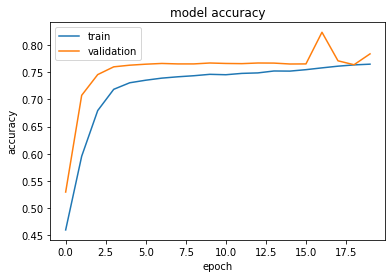

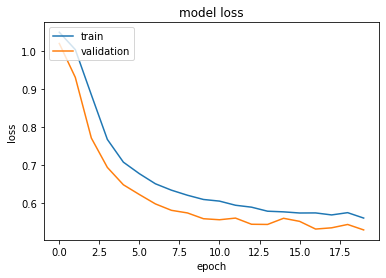

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

array([[ 173,   41, 1459],
       [  44, 2496,   52],
       [  23,   40, 3122]])

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

0.7773154362416107

In [ ]:
from sklearn import metrics
print(metrics.classification_report( list(map(lambda x: np.argmax(x), y_test)),  list(map(lambda x: np.argmax(x), y_hat)), digits=3))

              precision    recall  f1-score   support

           0      0.721     0.103     0.181      1673
           1      0.969     0.963     0.966      2592
           2      0.674     0.980     0.799      3185

    accuracy                          0.777      7450
   macro avg      0.788     0.682     0.648      7450
weighted avg      0.787     0.777     0.718      7450



Saving the model:

In [ ]:
#!mkdir -p home + saved_model
model.save(home + 'saved_model/model_1') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Corsi/cycle1/Text Mining and NLP - Prof. Marinai/Projectsaved_model/model_1/assets


In [ ]:
model = tf.keras.models.load_model(home+'saved_model/model_1')

# Check architecture
model.summary()

## Model 2: glove with trainable embeddings

creating a dictionary for the embadded words matrix

In [ ]:

embeddings_index = {}

f = open(os.path.join(home+"/archive/glove.6B.50d/full/glove.6B.50d.txt"))


for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 53004 unique tokens.


In [ ]:

max_features = 20000 # max number of words considered
num_words = min(max_features, len(embeddings_index)) +1
print(num_words)


20001


we run through all the words in our tokenizer and look for them in the glove model. If they exist we add them to our embedding matrix (ie our embeddings) if they don't then we assign a random vector

In [ ]:

# create a matrix of zeros as embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
present=0
absent=0
# for each word in out tokenizer lets try to find that work in our glove model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # if we find the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
        present+=1
    else:
        # if doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
        absent+=1

In [ ]:
print(f' {present} word have been found, {absent} have not')

 17856 word have been found, 2144 have not


We apply a CNN with the following characteristics

In [ ]:
embedding_dim = 50
num_filters = 5



inputs_2 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_2)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)

# relu activation
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = Flatten()(concatenated_tensor_3)

dropout_3 = Dropout(0.5)(flatten_3)
output_2 = Dense(units=3, activation='softmax')(dropout_3)
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1500, 50)     1000050     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1500, 50, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1498, 1, 5)   755         reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
batch_size = 50
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/20
477/477 [==============================] - 19s 38ms/step - loss: 1.7284 - accuracy: 0.4655 - val_loss: 1.0475 - val_accuracy: 0.5304
Epoch 2/20
477/477 [==============================] - 18s 37ms/step - loss: 1.0367 - accuracy: 0.5427 - val_loss: 0.9929 - val_accuracy: 0.6547
Epoch 3/20
477/477 [==============================] - 18s 37ms/step - loss: 0.9573 - accuracy: 0.6426 - val_loss: 0.8819 - val_accuracy: 0.7149
Epoch 4/20
477/477 [==============================] - 18s 37ms/step - loss: 0.8759 - accuracy: 0.6906 - val_loss: 0.7949 - val_accuracy: 0.7406
Epoch 5/20
477/477 [==============================] - 18s 37ms/step - loss: 0.8070 - accuracy: 0.7111 - val_loss: 0.7475 - val_accuracy: 0.7322
Epoch 6/20
477/477 [==============================] - 19s 39ms/step - loss: 0.7512 - accuracy: 0.7252 - val_loss: 0.6753 - val_accuracy: 0.7589
Epoch 7/20
477/477 [==============================] - 18s 37ms/step - loss: 0.7094 - accuracy: 0.7323 - val_loss: 0.6439 - val_accuracy:

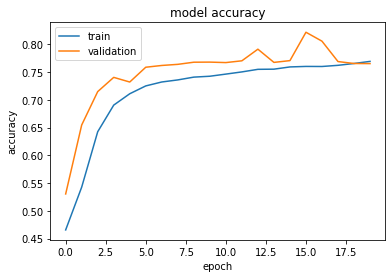

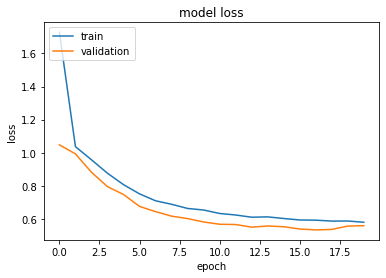

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_2 = model_2.predict(X_test)

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

array([[  50,   41, 1582],
       [  68, 2457,   67],
       [  21,   18, 3146]])

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

0.7587919463087248

In [ ]:
from sklearn import metrics
print(metrics.classification_report( list(map(lambda x: np.argmax(x), y_test)),  list(map(lambda x: np.argmax(x), y_hat_2)), digits=3))

              precision    recall  f1-score   support

           0      0.360     0.030     0.055      1673
           1      0.977     0.948     0.962      2592
           2      0.656     0.988     0.788      3185

    accuracy                          0.759      7450
   macro avg      0.664     0.655     0.602      7450
weighted avg      0.701     0.759     0.684      7450



Saving the model:

In [ ]:
model_2.save(home + 'saved_model/model_2') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Corsi/cycle1/Text Mining and NLP - Prof. Marinai/Projectsaved_model/model_2/assets


In [ ]:
model_2 = tf.keras.models.load_model(home + 'saved_model/model_2')

# Check architecture
model_2.summary()

###Test of new created instances:

In [ ]:
sentences =pd.DataFrame([["I do not trust him! is shameful"], 
                         ["good place for dinner! "], 
                         ["Italy is a member of european unio$n"], 
                         ["the candidate is untrustble and terrible!"],
                         ["the earth is a planet within the solar system"],
                         ["I'm very HAPPY for him"]])

#df['text'] = df['clean_comment'].apply(clean_str)

sentences['text'] = sentences[0].apply(clean_str)

token_sent = tokenizer.texts_to_sequences(sentences["text"].values)

sent_y = pad_sequences( token_sent , sequence_length)


sentences_hat = model.predict(sent_y)

indexes = tf.argmax(sentences_hat, axis=1)

for i in range(len(sentences)):
  print(indexes.numpy()[i], sentences['text'][i])




1 i do not trust him is shameful
2 good place for dinner
1 italy is a member of european union
0 the candidate is untrustble and terrible
1 the earth is a planet within the solar system
0 im very happy for him
